In [157]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/DS_DA_Projects/Marketing_Prediction")

data = pd.read_csv("data.csv", na_values=["", "NA"])

# DATA CLEANING

In [158]:
import pandas as pd
import numpy as np

# Replace missing or empty values in columns 4, 5, 6 with "unknown"
data.iloc[:, [3, 4, 5]] = data.iloc[:, [3, 4, 5]].applymap(lambda x: "unknown" if pd.isna(x) or x == "" else x)

# Replace income with appropriate midpoints or custom values
income_mapping = {
    "unknown": 6,              # replacing unknown with the median income level
    "Under $10k": 1,            # midpoint of "Under $10k"
    "10-19,999": 2,            # midpoint of "10-19,999"
    "20-29,999": 3,            # midpoint of "20-29,999"
    "30-39,999": 4,            # midpoint of "30-39,999"
    "40-49,999": 5,            # midpoint of "40-49,999"
    "50-59,999": 6,            # midpoint of "50-59,999"
    "60-69,999": 7,            # midpoint of "60-69,999"
    "70-79,999": 8,            # midpoint of "70-79,999"
    "80-89,999": 9,            # midpoint of "80-89,999"
    "90-99,999": 10,            # midpoint of "90-99,999"
    "100-149,999": 11,         # midpoint of "100-149,999"
    "150 - 174,999": 12,       # midpoint of "150 - 174,999"
    "175 - 199,999": 13,       # midpoint of "175 - 199,999"
    "200 - 249,999": 14,       # midpoint of "200 - 249,999"
    "250k+": 15               # custom value for "250k+"
}
data["income"] = data["income"].map(income_mapping).astype(int)

# Replace gender with 1 for male, 0 for female, and 0 for unknown
gender_mapping = {"M": 1, "F": 0, "unknown": 0}
data["gender"] = data["gender"].map(gender_mapping).astype(int)

# Replace marital_status with 1 for married, 0 for single, and 1 for unknown
marital_status_mapping = {"M": 1, "S": 0, "unknown": 1}
data["marital_status"] = data["marital_status"].map(marital_status_mapping).astype(int)

# Convert target to categorical values (0 or 1)
data["target"] = data["target"].astype(int)

# Convert distance (dist) column to integer
data["dist"] = data["dist"].astype(int)

/var/folders/2y/cbtx_pl154qczd091zb0d4z40000gn/T/ipykernel_56626/2211222545.py:5: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



# INTERACTION PLOT 

Optimization terminated successfully.
         Current function value: 0.535794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.542901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.541956
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.547609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.545148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.543849
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.559628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558019
  

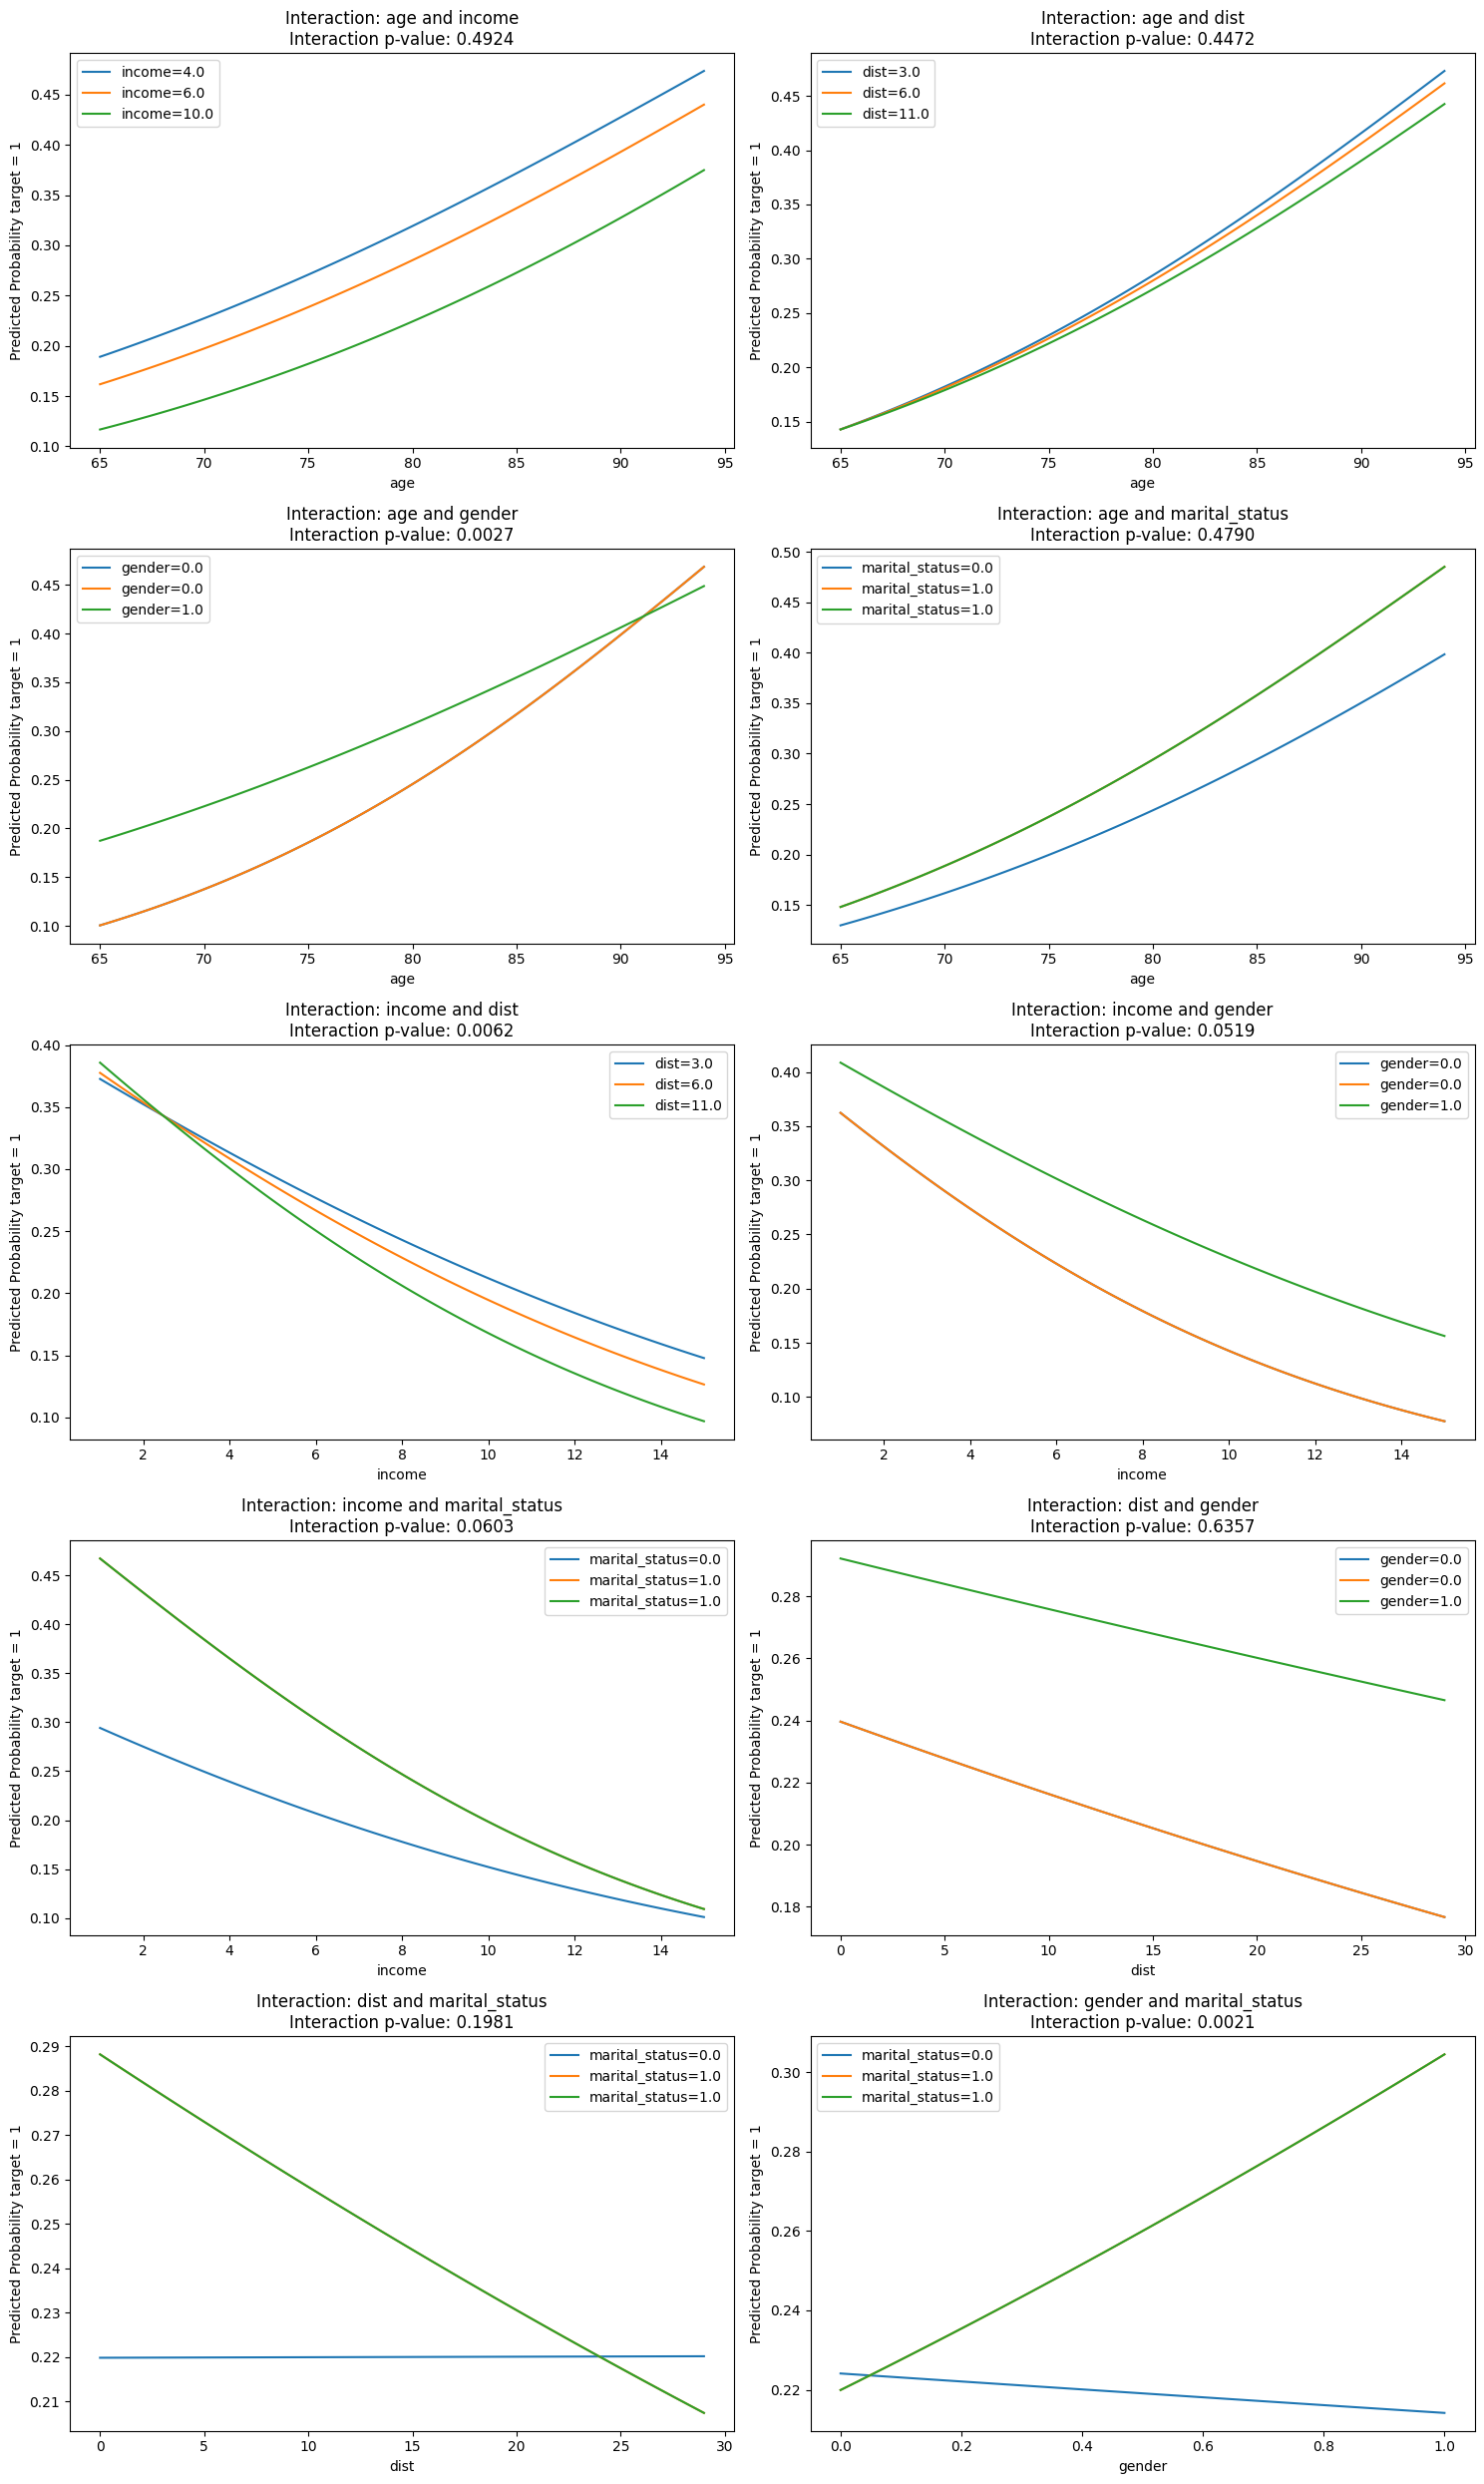


Significant interactions (p < 0.05):
age x gender
income x dist
gender x marital_status


In [159]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# List of numeric variables to check interactions
variables = ['age', 'income', 'dist', 'gender', 'marital_status']

# Create subplots for each pair of variables
n_pairs = len(variables) * (len(variables) - 1) // 2
n_rows = (n_pairs + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows))
axes = axes.flatten()

# Store significant interactions
significant_interactions = []
plot_idx = 0

for i, var1 in enumerate(variables):
    for j, var2 in enumerate(variables[i+1:], i+1):
        # Fit logistic regression with interaction
        formula = f'target ~ {var1} * {var2}'
        model = sm.Logit.from_formula(formula, data=data).fit()
        
        # Get p-value for interaction term
        interaction_pvalue = model.pvalues[f'{var1}:{var2}']
        
        # Store significant interactions
        if interaction_pvalue < 0.05:
            significant_interactions.append((var1, var2))
        
        # Generate range of values for var1
        var1_values = np.linspace(data[var1].min(), data[var1].max(), 100)
        
        # Get representative values for var2 (quartiles)
        var2_levels = np.percentile(data[var2], [25, 50, 75])
        
        # Plot interactions
        for var2_level in var2_levels:
            df = pd.DataFrame({
                var1: var1_values,
                var2: var2_level
            })
            df['interaction'] = df[var1] * df[var2]
            df['predicted_prob'] = model.predict(sm.add_constant(df))
            
            axes[plot_idx].plot(df[var1], df['predicted_prob'], 
                              label=f'{var2}={var2_level:.1f}')
        
        axes[plot_idx].set_xlabel(var1)
        axes[plot_idx].set_ylabel('Predicted Probability target = 1')
        axes[plot_idx].legend()
        axes[plot_idx].set_title(f'Interaction: {var1} and {var2}\nInteraction p-value: {interaction_pvalue:.4f}')
        plot_idx += 1

# Remove any empty subplots
for idx in range(plot_idx, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

print("\nSignificant interactions (p < 0.05):")
for var1, var2 in significant_interactions:
    print(f"{var1} x {var2}")

# LOGISTIC REGRESSION MODEL

What if we just started with the logistic regression model without checking the data?

In [160]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Prepare features (X) and target (y)
X = data[['age', 'dist', 'income', 'gender', 'marital_status']]
y = data['target']

# Add a constant (intercept) to the features
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the logistic regression model with increased max_iter
log_reg = LogisticRegression(random_state=42, fit_intercept=True, max_iter=1000)
log_reg.fit(X_train, y_train)

# Print model parameters including intercept
print("Model Intercept:", log_reg.intercept_[0])
print("\nFeature Coefficients:")
for feature, coef in zip(X.columns[1:], log_reg.coef_[0][1:]):  # Skip the constant column
    print(f"{feature}: {coef:.4f}")

# Calculate and print the model accuracy
train_accuracy = log_reg.score(X_train, y_train)
test_accuracy = log_reg.score(X_test, y_test)

print(f"\nTraining Accuracy: {train_accuracy:.3f}")
print(f"Testing Accuracy: {test_accuracy:.3f}")

Model Intercept: -4.5547880441748685

Feature Coefficients:
age: 0.0488
dist: -0.0162
income: -0.1106
gender: 0.4162
marital_status: 0.4290

Training Accuracy: 0.754
Testing Accuracy: 0.715


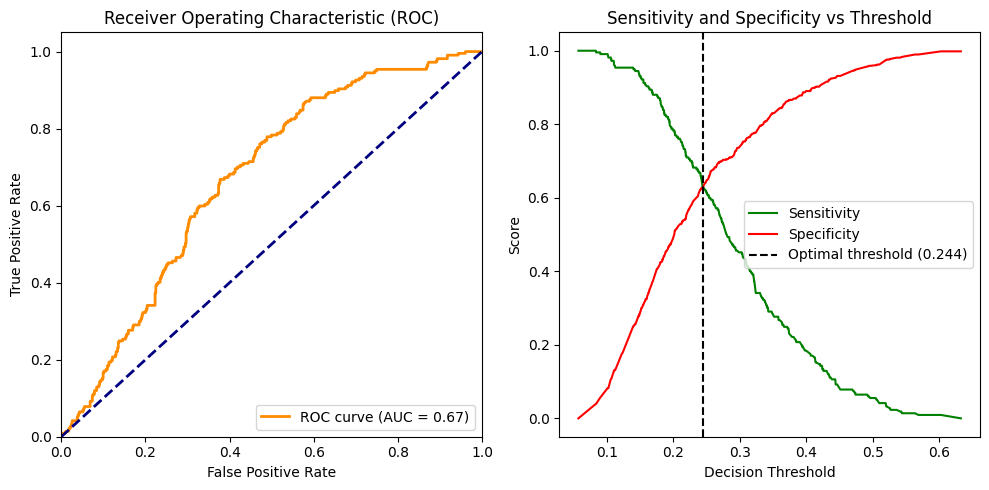

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get prediction probabilities
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Calculate sensitivity and specificity for different thresholds
sensitivity = tpr
specificity = 1 - fpr

# Find optimal threshold where sensitivity and specificity are closest
differences = np.abs(sensitivity - specificity)
optimal_idx = np.argmin(differences)
optimal_threshold = thresholds[optimal_idx]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot ROC curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC)')
ax1.legend(loc="lower right")

# Plot sensitivity/specificity vs threshold
ax2.plot(thresholds, sensitivity, label='Sensitivity', color='green')
ax2.plot(thresholds, specificity, label='Specificity', color='red')
ax2.axvline(x=optimal_threshold, color='black', linestyle='--', label=f'Optimal threshold ({optimal_threshold:.3f})')
ax2.set_xlabel('Decision Threshold')
ax2.set_ylabel('Score')
ax2.set_title('Sensitivity and Specificity vs Threshold')
ax2.legend()

plt.tight_layout()
plt.show()

Optimal threshold: 0.244
At this threshold:
Sensitivity: 0.627
Specificity: 0.628


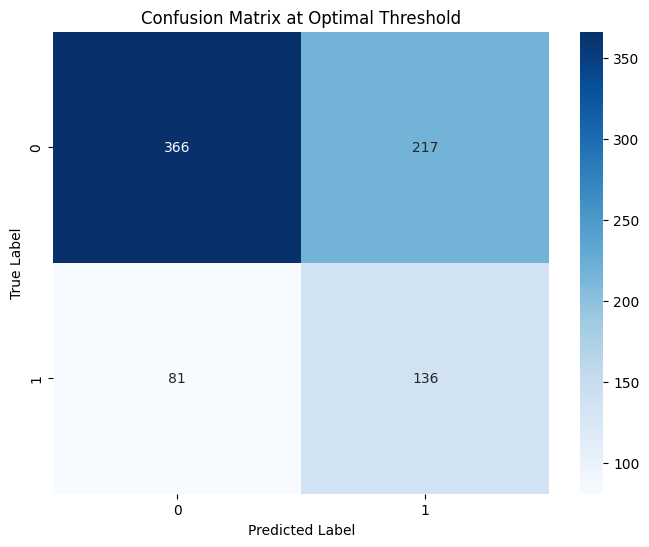

In [162]:
# Find optimal threshold where sensitivity and specificity are closest
differences = np.abs(sensitivity - specificity)
optimal_idx = np.argmin(differences)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"At this threshold:")
print(f"Sensitivity: {sensitivity[optimal_idx]:.3f}")
print(f"Specificity: {specificity[optimal_idx]:.3f}")

# Get predictions using optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Calculate and plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_optimal)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix at Optimal Threshold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# 63% at optimal threshold

Lift Chart for Logistic Regression Model:

Logistic Regression Lift Chart Data:


,Lift Curve,Baseline,Lift
0,0.0,0.0,0.0
1,15.6,10.0,5.6
2,31.4,20.0,11.4
3,46.5,30.0,16.5
4,61.3,40.0,21.3
5,72.1,50.0,22.1
6,78.9,60.0,18.9
7,85.8,70.0,15.8
8,92.0,80.0,12.0
9,97.2,90.0,7.2


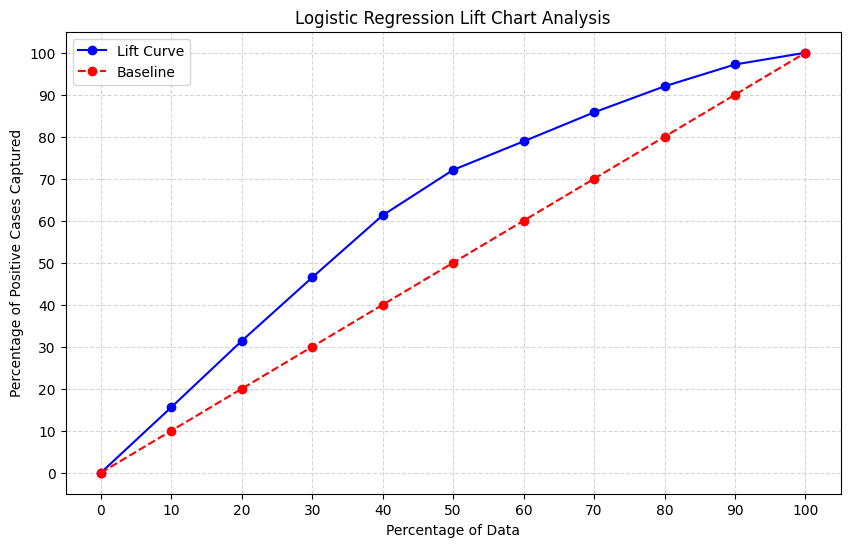

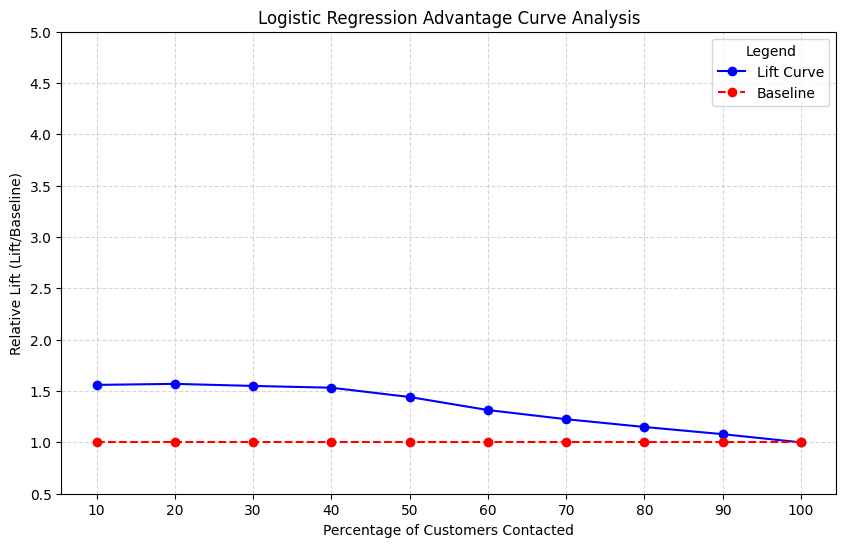


Top rows of sorted data (by predicted probabilities):


,id,age,dist,income,gender,marital_status,target,predicted_probs
3917,3918,94,1,2,1,1,0,0.655432
2393,2394,94,2,2,1,1,1,0.651772
442,443,94,3,2,1,1,1,0.648094
2151,2152,94,0,3,1,1,0,0.633796
460,461,92,1,2,1,1,1,0.633055



Top rows of shuffled data (random order):


,id,age,dist,income,gender,marital_status,target,predicted_probs
0,556,77,5,11,0,0,0,0.109804
1,3492,82,3,11,1,1,1,0.274687
2,528,80,3,11,0,1,0,0.184691
3,3926,73,1,3,1,0,0,0.284534
4,2990,69,5,2,1,1,0,0.344707


In [163]:
# Train Logistic Regression model and get predictions for lift chart
predictors = ['age', 'income', 'dist', 'gender', 'marital_status']
target = 'target'

# Split data into training and test sets
X = data[predictors]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit Logistic Regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

# Predict probabilities for the entire dataset
data['predicted_probs'] = lr_model.predict_proba(X)[:, 1]

# Sort and shuffle data
data_sorted_lr = data.sort_values(by='predicted_probs', ascending=False)
data_shuffled_lr = data.sample(frac=1, random_state=42).reset_index(drop=True)

def lift_chart(sorted_data, shuffled_data):
    """
    Computes and plots the lift chart comparing sorted vs shuffled data
    
    Parameters:
    - sorted_data: DataFrame sorted by predicted probabilities
    - shuffled_data: DataFrame in random order
    """
    # Calculate cumulative positives at each decile
    total_positives = sorted_data['target'].sum()
    n_rows = len(sorted_data)
    
    lift_curve = []
    baseline_curve = []
    
    for i in range(11):
        cutoff = int((i/10) * n_rows)
        
        # Lift curve from sorted data
        lift_percentage = sorted_data.iloc[:cutoff]['target'].sum() / total_positives * 100
        lift_curve.append(lift_percentage)
        
        # Baseline from shuffled data 
        baseline_percentage = (i/10) * 100
        baseline_curve.append(baseline_percentage)
    
    # Create results DataFrame
    lift_data = pd.DataFrame({
        'Lift Curve': lift_curve,
        'Baseline': baseline_curve
    })
    lift_data['Lift'] = lift_data['Lift Curve'] - lift_data['Baseline']
    
    print("\nLogistic Regression Lift Chart Data:")
    display(lift_data)
    
    # Plot lift chart
    plt.figure(figsize=(10, 6))
    plt.plot(np.linspace(0, 100, 11), lift_data['Lift Curve'],
             label='Lift Curve', color='blue', marker='o')
    plt.plot(np.linspace(0, 100, 11), lift_data['Baseline'],
             label='Baseline', color='red', linestyle='--', marker='o')
    
    plt.title('Logistic Regression Lift Chart Analysis')
    plt.xlabel('Percentage of Data')
    plt.ylabel('Percentage of Positive Cases Captured')
    plt.xticks(np.linspace(0, 100, 11))
    plt.yticks(np.linspace(0, 100, 11))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    
    # Calculate and plot advantage curve
    advantage_data = lift_data.copy()
    advantage_data['Lift Curve'] = advantage_data['Lift Curve'] / advantage_data['Baseline']
    advantage_data['Baseline'] = advantage_data['Baseline'] / advantage_data['Baseline']
    advantage_data = advantage_data.iloc[1:] # Remove first row to avoid division by zero
    
    plt.figure(figsize=(10, 6))
    plt.plot(np.linspace(10, 100, 10), advantage_data['Lift Curve'],
             label='Lift Curve', color='blue', marker='o')
    plt.plot(np.linspace(10, 100, 10), advantage_data['Baseline'],
             label='Baseline', color='red', linestyle='--', marker='o')
    
    plt.title('Logistic Regression Advantage Curve Analysis')
    plt.xlabel('Percentage of Customers Contacted')
    plt.ylabel('Relative Lift (Lift/Baseline)')
    plt.xticks(np.linspace(10, 100, 10))
    plt.ylim(0.5, 5)
    plt.legend(title='Legend')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    
    return lift_data

# Generate lift chart
print("Lift Chart for Logistic Regression Model:")
lift_data_lr = lift_chart(data_sorted_lr, data_shuffled_lr)

print("\nTop rows of sorted data (by predicted probabilities):")
display(data_sorted_lr.head())

print("\nTop rows of shuffled data (random order):")
display(data_shuffled_lr.head())


# updated logistic regression model - with interactions

Model Intercept: -5.246784645687027

Feature Coefficients:
age: 0.0553
dist: 0.0145
income: -0.0703
gender: 1.2751
marital_status: 0.3339
age_gender_interaction: -0.0129
income_dist_interaction: -0.0055
gender_marital_status_interaction: 0.2088

Training Accuracy: 0.754
Testing Accuracy: 0.724


/var/folders/2y/cbtx_pl154qczd091zb0d4z40000gn/T/ipykernel_56626/135717481.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/2y/cbtx_pl154qczd091zb0d4z40000gn/T/ipykernel_56626/135717481.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



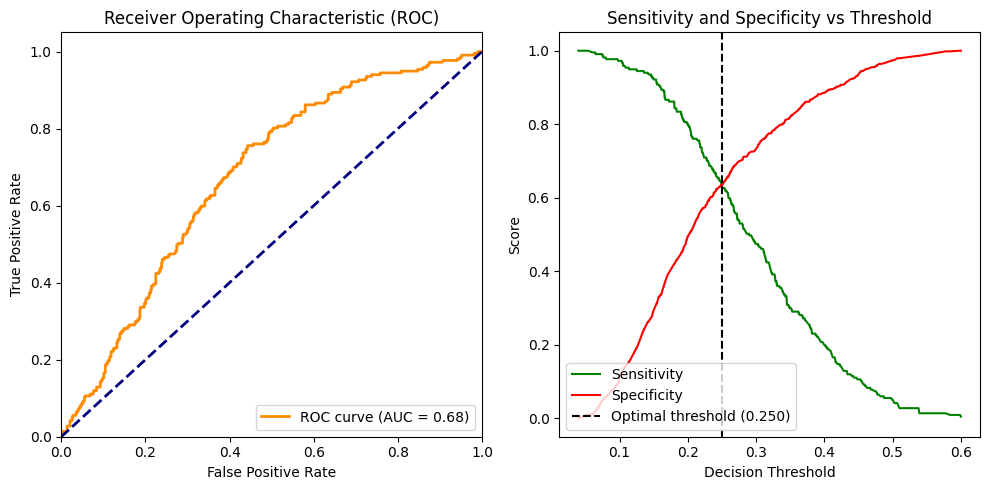

Optimal threshold: 0.250
At this threshold:
Sensitivity: 0.627
Specificity: 0.635


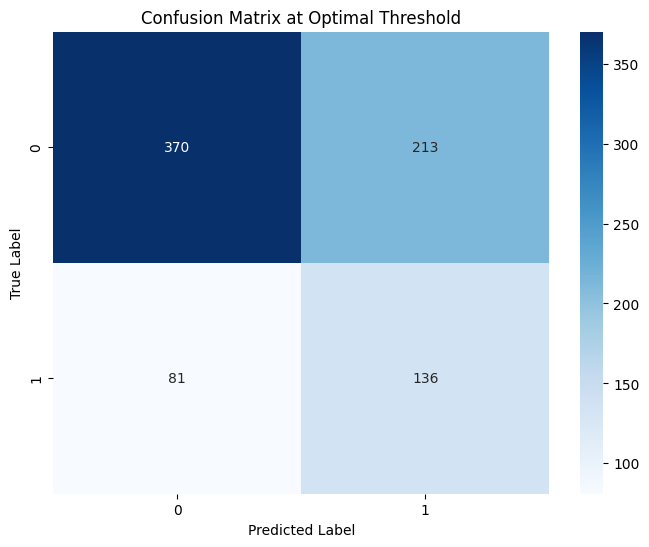


Logistic Regression Lift Chart Data:


,Lift Curve,Baseline,Lift
0,0.0,0.0,0.0
1,16.1,10.0,6.1
2,32.7,20.0,12.7
3,47.8,30.0,17.8
4,60.9,40.0,20.9
5,71.6,50.0,21.6
6,79.2,60.0,19.2
7,85.1,70.0,15.1
8,92.4,80.0,12.4
9,96.6,90.0,6.6


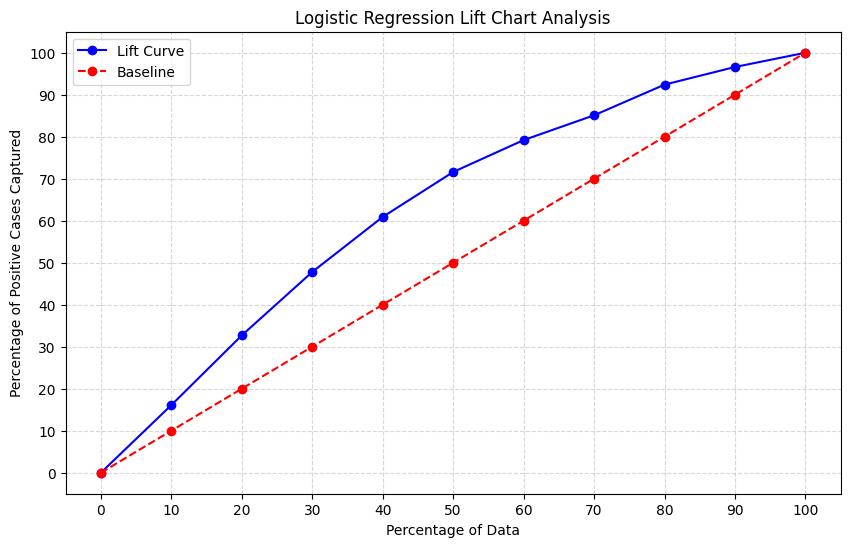

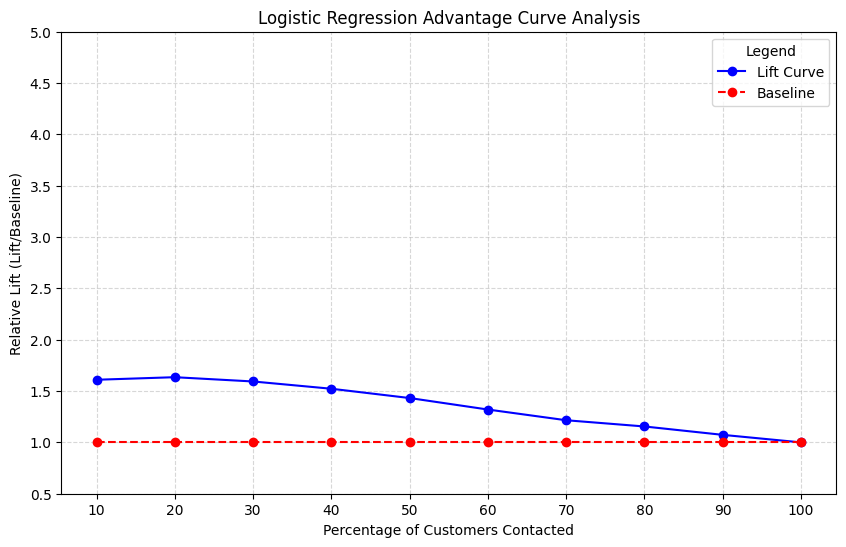


Top rows of sorted data (by predicted probabilities):


,id,age,dist,income,gender,marital_status,target,predicted_probs
1831,1832,93,17,2,1,1,0,0.607556
442,443,94,3,2,1,1,1,0.606198
2393,2394,94,2,2,1,1,1,0.605378
3917,3918,94,1,2,1,1,0,0.604556
2113,2114,90,11,1,1,1,1,0.603583



Top rows of shuffled data (random order):


,id,age,dist,income,gender,marital_status,target,predicted_probs
0,556,77,5,11,0,0,0,0.120603
1,3492,82,3,11,1,1,1,0.297320
2,528,80,3,11,0,1,0,0.198755
3,3926,73,1,3,1,0,0,0.252614
4,2990,69,5,2,1,1,0,0.349320


In [164]:
# LOGISTIC REGRESSION MODEL WITH INTERACTIONS

# Prepare features (X) and target (y)
X = data[['age', 'dist', 'income', 'gender', 'marital_status']]
y = data['target']

# Add interaction terms for significant interactions
for var1, var2 in significant_interactions:
    interaction_name = f'{var1}_{var2}_interaction'
    X[interaction_name] = X[var1] * X[var2]

# Add a constant (intercept) to the features
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the logistic regression model with increased max_iter
log_reg = LogisticRegression(random_state=42, fit_intercept=True, max_iter=1000)
log_reg.fit(X_train, y_train)

# Print model parameters including intercept
print("Model Intercept:", log_reg.intercept_[0])
print("\nFeature Coefficients:")
for feature, coef in zip(X.columns[1:], log_reg.coef_[0][1:]):  # Skip the constant column
    print(f"{feature}: {coef:.4f}")

# Calculate and print the model accuracy
train_accuracy = log_reg.score(X_train, y_train)
test_accuracy = log_reg.score(X_test, y_test)

print(f"\nTraining Accuracy: {train_accuracy:.3f}")
print(f"Testing Accuracy: {test_accuracy:.3f}")

# ROC Curve and Threshold Analysis
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Calculate sensitivity and specificity
sensitivity = tpr
specificity = 1 - fpr

# Find optimal threshold
differences = np.abs(sensitivity - specificity)
optimal_idx = np.argmin(differences)
optimal_threshold = thresholds[optimal_idx]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot ROC curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC)')
ax1.legend(loc="lower right")

# Plot sensitivity/specificity vs threshold
ax2.plot(thresholds, sensitivity, label='Sensitivity', color='green')
ax2.plot(thresholds, specificity, label='Specificity', color='red')
ax2.axvline(x=optimal_threshold, color='black', linestyle='--', label=f'Optimal threshold ({optimal_threshold:.3f})')
ax2.set_xlabel('Decision Threshold')
ax2.set_ylabel('Score')
ax2.set_title('Sensitivity and Specificity vs Threshold')
ax2.legend()

plt.tight_layout()
plt.show()

# Print threshold metrics and confusion matrix
print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"At this threshold:")
print(f"Sensitivity: {sensitivity[optimal_idx]:.3f}")
print(f"Specificity: {specificity[optimal_idx]:.3f}")

# Get predictions using optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Calculate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred_optimal)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix at Optimal Threshold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Lift Chart Analysis
# Get predictions for entire dataset
data['predicted_probs'] = log_reg.predict_proba(X)[:, 1]

# Sort and shuffle data
data_sorted = data.sort_values(by='predicted_probs', ascending=False)
data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Calculate lift chart data
total_positives = data_sorted['target'].sum()
n_rows = len(data_sorted)

lift_curve = []
baseline_curve = []

for i in range(11):
    cutoff = int((i/10) * n_rows)
    lift_percentage = data_sorted.iloc[:cutoff]['target'].sum() / total_positives * 100
    baseline_percentage = (i/10) * 100
    lift_curve.append(lift_percentage)
    baseline_curve.append(baseline_percentage)

# Create lift chart DataFrame
lift_data = pd.DataFrame({
    'Lift Curve': lift_curve,
    'Baseline': baseline_curve
})
lift_data['Lift'] = lift_data['Lift Curve'] - lift_data['Baseline']

# Display lift chart data
print("\nLogistic Regression Lift Chart Data:")
display(lift_data)

# Plot lift chart
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, 100, 11), lift_data['Lift Curve'],
         label='Lift Curve', color='blue', marker='o')
plt.plot(np.linspace(0, 100, 11), lift_data['Baseline'],
         label='Baseline', color='red', linestyle='--', marker='o')

plt.title('Logistic Regression Lift Chart Analysis')
plt.xlabel('Percentage of Data')
plt.ylabel('Percentage of Positive Cases Captured')
plt.xticks(np.linspace(0, 100, 11))
plt.yticks(np.linspace(0, 100, 11))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Plot advantage curve
advantage_data = lift_data.copy()
advantage_data['Lift Curve'] = advantage_data['Lift Curve'] / advantage_data['Baseline']
advantage_data['Baseline'] = advantage_data['Baseline'] / advantage_data['Baseline']
advantage_data = advantage_data.iloc[1:] # Remove first row to avoid division by zero

plt.figure(figsize=(10, 6))
plt.plot(np.linspace(10, 100, 10), advantage_data['Lift Curve'],
         label='Lift Curve', color='blue', marker='o')
plt.plot(np.linspace(10, 100, 10), advantage_data['Baseline'],
         label='Baseline', color='red', linestyle='--', marker='o')

plt.title('Logistic Regression Advantage Curve Analysis')
plt.xlabel('Percentage of Customers Contacted')
plt.ylabel('Relative Lift (Lift/Baseline)')
plt.xticks(np.linspace(10, 100, 10))
plt.ylim(0.5, 5)
plt.legend(title='Legend')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Display preview of sorted and shuffled data
print("\nTop rows of sorted data (by predicted probabilities):")
display(data_sorted.head())

print("\nTop rows of shuffled data (random order):")
display(data_shuffled.head())

# Checking for non-linear relationships

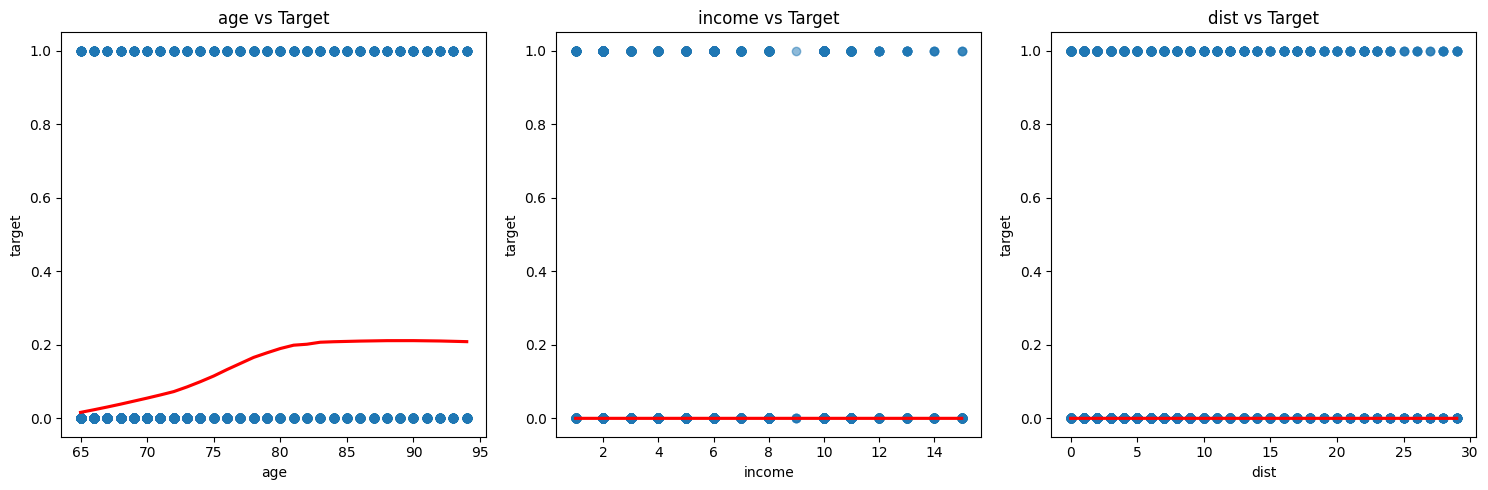

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create subplots for each numerical variable
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
numerical_vars = ['age', 'income', 'dist']

for i, var in enumerate(numerical_vars):
    # Create scatter plot with lowess smoothing
    sns.regplot(data=data, x=var, y='target', ax=axes[i], 
                scatter_kws={'alpha':0.5}, 
                lowess=True, # Add LOWESS smoothing line
                line_kws={'color': 'red'})
    axes[i].set_title(f'{var} vs Target')

plt.tight_layout()
plt.show()

# complex interactions beyond pairwise

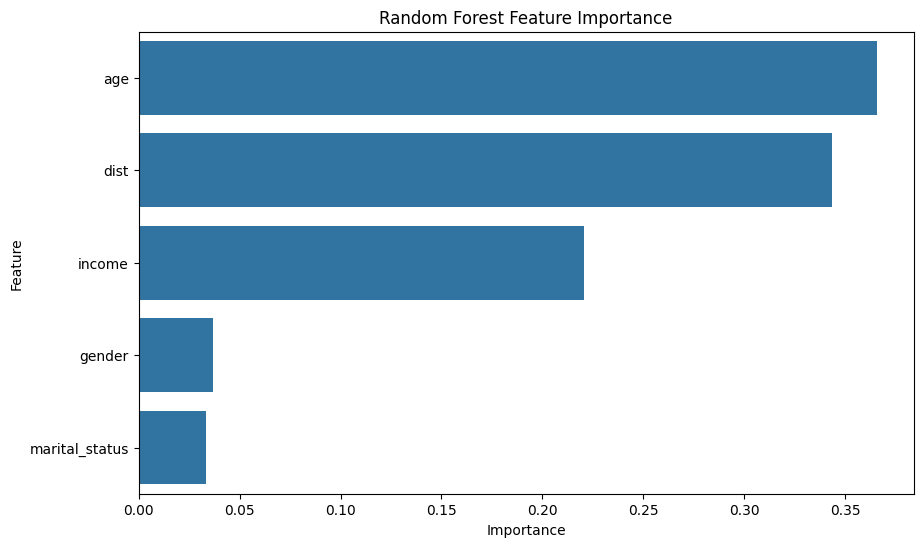

In [171]:
# Get feature importance from Random Forest
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
importances = importances.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=importances, x='importance', y='feature')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# threshold effects 

/var/folders/2y/cbtx_pl154qczd091zb0d4z40000gn/T/ipykernel_56626/3533205154.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/2y/cbtx_pl154qczd091zb0d4z40000gn/T/ipykernel_56626/3533205154.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/2y/cbtx_pl154qczd091zb0d4z40000gn/T/ipykernel_56626/3533205154.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



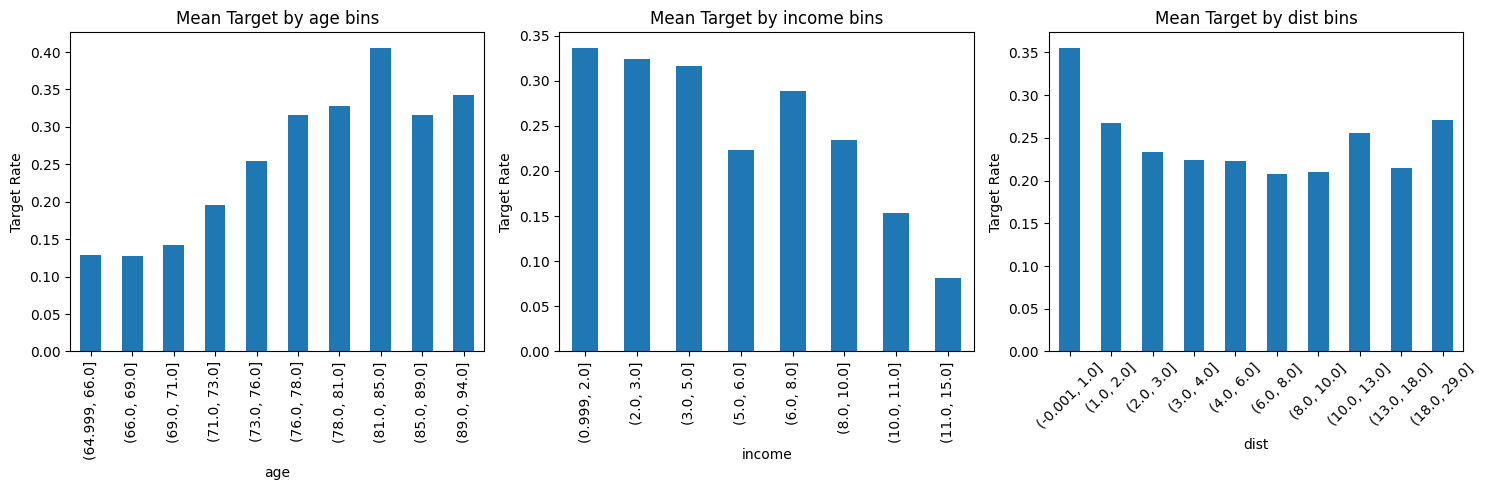

In [172]:
# Create binned versions of numerical variables
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, var in enumerate(numerical_vars):
    # Create bins and calculate mean target value
    bins = pd.qcut(data[var], q=10, duplicates='drop')
    means = data.groupby(bins)['target'].mean()
    
    # Plot
    means.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Mean Target by {var} bins')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Target Rate')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# RANDOM FOREST MODEL

Lift Chart for Random Forest Model:

Random Forest Lift Chart Data:


,Lift Curve,Baseline,Lift
0,0.0,0.0,0.0
1,37.7,10.0,27.7
2,72.8,20.0,52.8
3,88.6,30.0,58.6
4,91.9,40.0,51.9
5,95.2,50.0,45.2
6,96.6,60.0,36.6
7,98.0,70.0,28.0
8,99.1,80.0,19.1
9,99.4,90.0,9.4


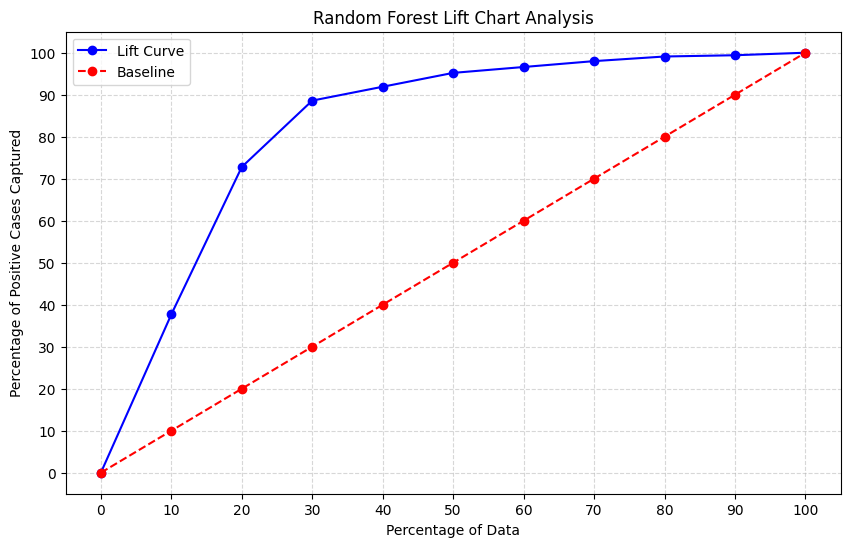

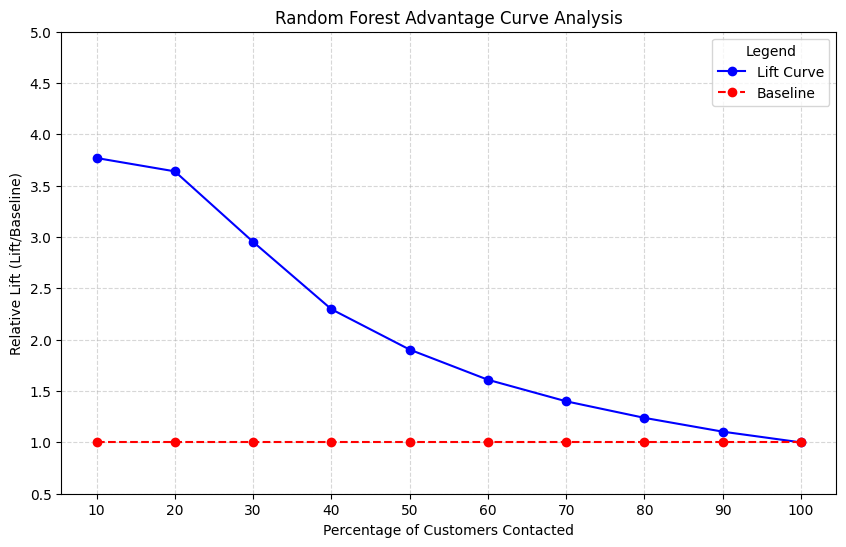


Top rows of sorted data (by predicted probabilities):


,id,age,dist,income,gender,marital_status,target,predicted_probs
2726,2727,79,0,2,0,1,1,0.99
2071,2072,79,0,2,0,1,1,0.99
1016,1017,77,5,11,1,1,1,0.98
246,247,85,0,6,1,1,1,0.98
171,172,77,5,11,1,1,1,0.98



Top rows of shuffled data (random order):


,id,age,dist,income,gender,marital_status,target,predicted_probs
0,556,77,5,11,0,0,0,0.050
1,3492,82,3,11,1,1,1,0.080
2,528,80,3,11,0,1,0,0.250
3,3926,73,1,3,1,0,0,0.205
4,2990,69,5,2,1,1,0,0.285


In [165]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Train Random Forest model and get predictions for lift chart
predictors = ['age', 'income', 'dist', 'gender', 'marital_status']
target = 'target'

# Split data into training and test sets
X = data[predictors]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict probabilities for the entire dataset
data['predicted_probs'] = rf_model.predict_proba(X)[:, 1]

# Sort and shuffle data
data_sorted_rf = data.sort_values(by='predicted_probs', ascending=False)
data_shuffled_rf = data.sample(frac=1, random_state=42).reset_index(drop=True)

def lift_chart(sorted_data, shuffled_data):
    """
    Computes and plots the lift chart comparing sorted vs shuffled data
    
    Parameters:
    - sorted_data: DataFrame sorted by predicted probabilities
    - shuffled_data: DataFrame in random order
    """
    # Calculate cumulative positives at each decile
    total_positives = sorted_data['target'].sum()
    n_rows = len(sorted_data)
    
    lift_curve = []
    baseline_curve = []
    
    for i in range(11):
        cutoff = int((i/10) * n_rows)
        
        # Lift curve from sorted data
        lift_percentage = sorted_data.iloc[:cutoff]['target'].sum() / total_positives * 100
        lift_curve.append(lift_percentage)
        
        # Baseline from shuffled data 
        baseline_percentage = (i/10) * 100
        baseline_curve.append(baseline_percentage)
    
    # Create results DataFrame
    lift_data = pd.DataFrame({
        'Lift Curve': lift_curve,
        'Baseline': baseline_curve
    })
    lift_data['Lift'] = lift_data['Lift Curve'] - lift_data['Baseline']
    
    print("\nRandom Forest Lift Chart Data:")
    display(lift_data)
    
    # Plot lift chart
    plt.figure(figsize=(10, 6))
    plt.plot(np.linspace(0, 100, 11), lift_data['Lift Curve'],
             label='Lift Curve', color='blue', marker='o')
    plt.plot(np.linspace(0, 100, 11), lift_data['Baseline'],
             label='Baseline', color='red', linestyle='--', marker='o')
    
    plt.title('Random Forest Lift Chart Analysis')
    plt.xlabel('Percentage of Data')
    plt.ylabel('Percentage of Positive Cases Captured')
    plt.xticks(np.linspace(0, 100, 11))
    plt.yticks(np.linspace(0, 100, 11))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    
    # Calculate and plot advantage curve
    advantage_data = lift_data.copy()
    advantage_data['Lift Curve'] = advantage_data['Lift Curve'] / advantage_data['Baseline']
    advantage_data['Baseline'] = advantage_data['Baseline'] / advantage_data['Baseline']
    advantage_data = advantage_data.iloc[1:] # Remove first row to avoid division by zero
    
    plt.figure(figsize=(10, 6))
    plt.plot(np.linspace(10, 100, 10), advantage_data['Lift Curve'],
             label='Lift Curve', color='blue', marker='o')
    plt.plot(np.linspace(10, 100, 10), advantage_data['Baseline'],
             label='Baseline', color='red', linestyle='--', marker='o')
    
    plt.title('Random Forest Advantage Curve Analysis')
    plt.xlabel('Percentage of Customers Contacted')
    plt.ylabel('Relative Lift (Lift/Baseline)')
    plt.xticks(np.linspace(10, 100, 10))
    plt.ylim(0.5, 5)
    plt.legend(title='Legend')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    
    return lift_data

# Generate lift chart
print("Lift Chart for Random Forest Model:")
lift_data_rf = lift_chart(data_sorted_rf, data_shuffled_rf)

print("\nTop rows of sorted data (by predicted probabilities):")
display(data_sorted_rf.head())

print("\nTop rows of shuffled data (random order):")
display(data_shuffled_rf.head())


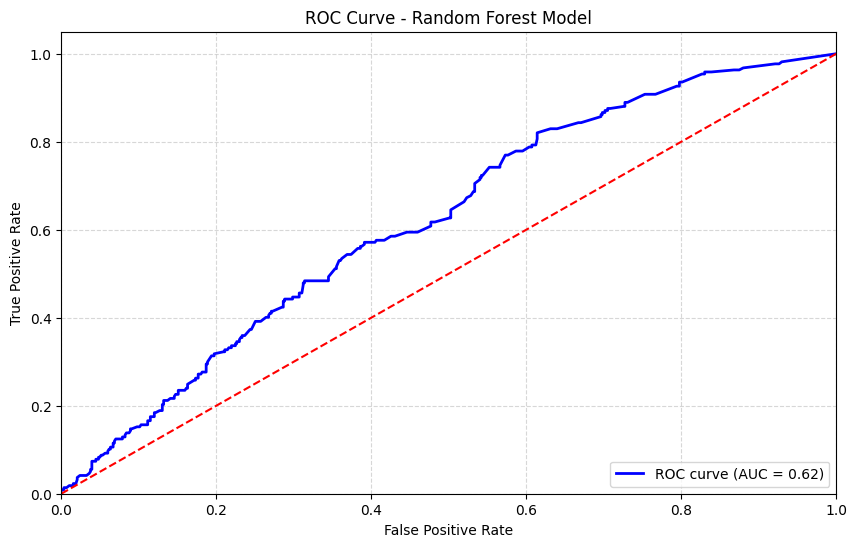

In [166]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Model')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


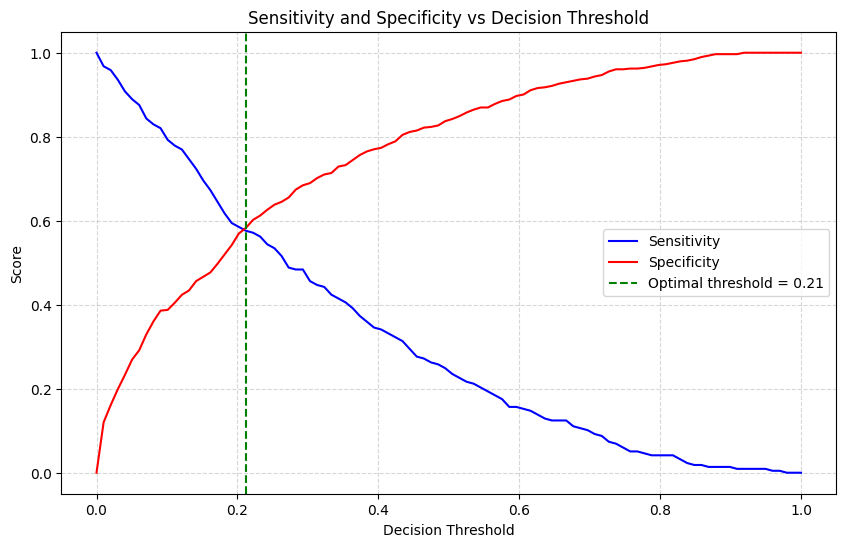

In [167]:
# Calculate sensitivity and specificity for different thresholds
thresholds = np.linspace(0, 1, 100)
sensitivity = []
specificity = []

y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # True Positive Rate (Sensitivity)
    tp = np.sum((y_test == 1) & (y_pred == 1))
    fn = np.sum((y_test == 1) & (y_pred == 0))
    sensitivity.append(tp / (tp + fn))
    
    # True Negative Rate (Specificity) 
    tn = np.sum((y_test == 0) & (y_pred == 0))
    fp = np.sum((y_test == 0) & (y_pred == 1))
    specificity.append(tn / (tn + fp))

# Find threshold where sensitivity and specificity are closest
differences = np.abs(np.array(sensitivity) - np.array(specificity))
optimal_idx = np.argmin(differences)
optimal_threshold = thresholds[optimal_idx]

# Plot sensitivity and specificity vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, sensitivity, label='Sensitivity', color='blue')
plt.plot(thresholds, specificity, label='Specificity', color='red')
plt.axvline(x=optimal_threshold, color='green', linestyle='--', 
           label=f'Optimal threshold = {optimal_threshold:.2f}')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.title('Sensitivity and Specificity vs Decision Threshold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


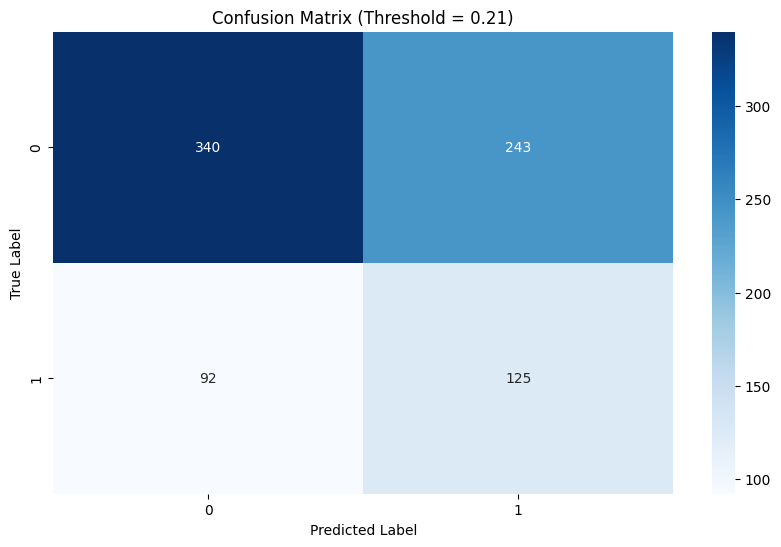

In [168]:
# Generate predictions using optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Create and plot confusion matrix
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix (Threshold = {optimal_threshold:.2f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


57% at optimal threshold

# updated random forest model

Training Accuracy: 0.973
Testing Accuracy: 0.680


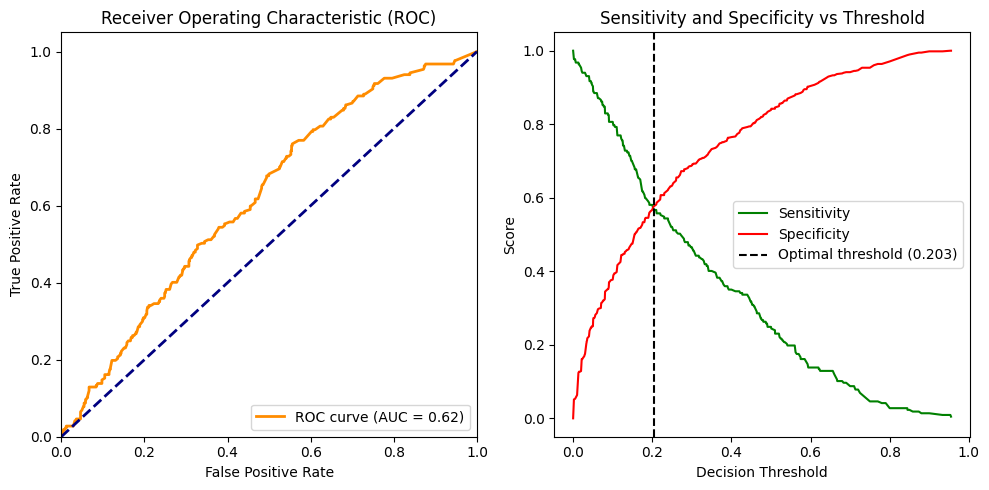

Optimal threshold: 0.203
At this threshold:
Sensitivity: 0.567
Specificity: 0.576


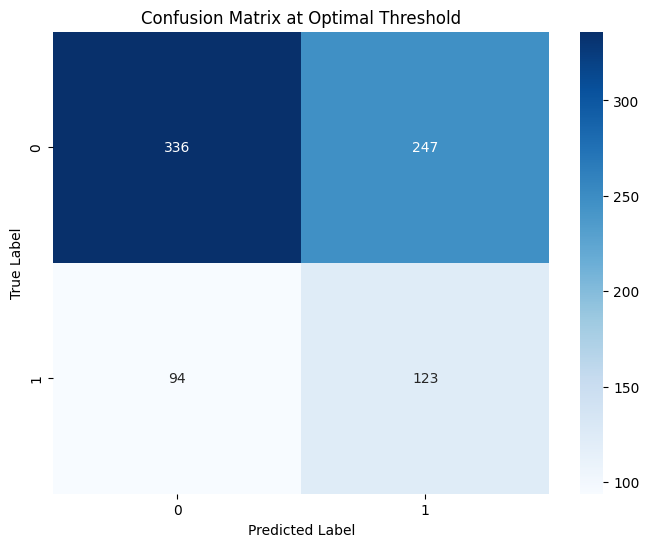


Random Forest Lift Chart Data:


,Lift Curve,Baseline,Lift
0,0.0,0.0,0.0
1,37.3,10.0,27.3
2,72.9,20.0,52.9
3,88.7,30.0,58.7
4,92.2,40.0,52.2
5,95.0,50.0,45.0
6,96.7,60.0,36.7
7,98.1,70.0,28.1
8,98.8,80.0,18.8
9,99.3,90.0,9.3


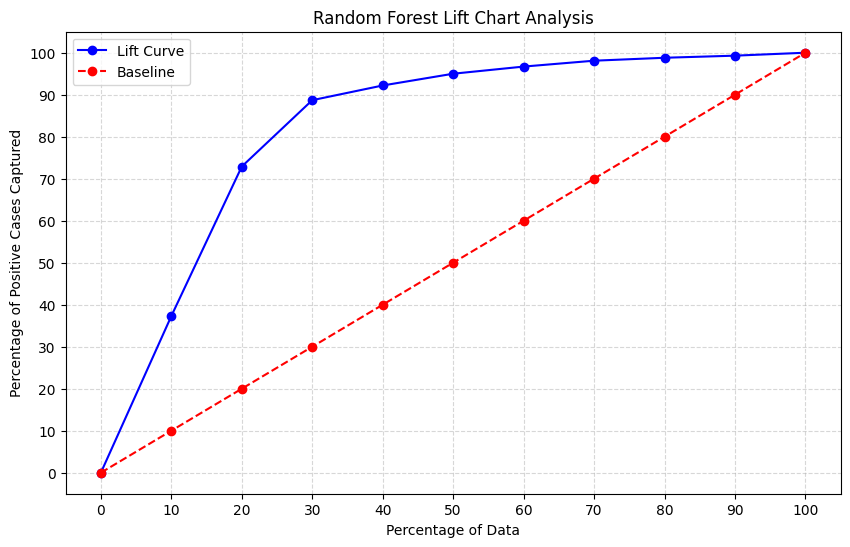

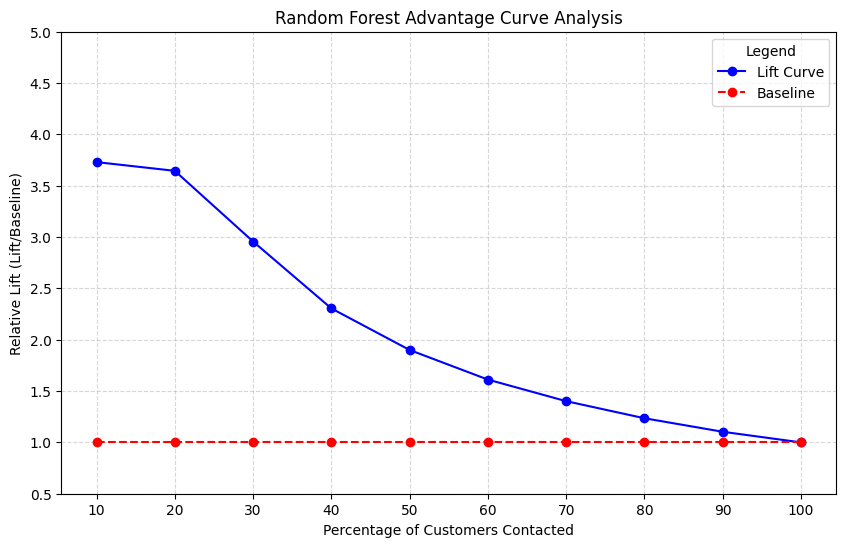


Top rows of sorted data (by predicted probabilities):


,id,age,dist,income,gender,marital_status,target,predicted_probs
585,586,80,16,4,1,1,1,0.99
1804,1805,80,16,4,1,1,1,0.99
2726,2727,79,0,2,0,1,1,0.98
171,172,77,5,11,1,1,1,0.98
702,703,85,2,10,1,1,1,0.98



Top rows of shuffled data (random order):


,id,age,dist,income,gender,marital_status,target,predicted_probs
0,556,77,5,11,0,0,0,0.080
1,3492,82,3,11,1,1,1,0.060
2,528,80,3,11,0,1,0,0.160
3,3926,73,1,3,1,0,0,0.255
4,2990,69,5,2,1,1,0,0.285


In [169]:
# 1. Train Random Forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Prepare features (X) and target (y)
X = data[['age', 'dist', 'income', 'gender', 'marital_status']]
y = data['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Calculate and print model accuracy
train_accuracy = rf_model.score(X_train, y_train)
test_accuracy = rf_model.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Testing Accuracy: {test_accuracy:.3f}")

# 2. ROC Curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get prediction probabilities
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Calculate sensitivity and specificity
sensitivity = tpr
specificity = 1 - fpr

# Find optimal threshold
differences = np.abs(sensitivity - specificity)
optimal_idx = np.argmin(differences)
optimal_threshold = thresholds[optimal_idx]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot ROC curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC)')
ax1.legend(loc="lower right")

# Plot sensitivity/specificity vs threshold
ax2.plot(thresholds, sensitivity, label='Sensitivity', color='green')
ax2.plot(thresholds, specificity, label='Specificity', color='red')
ax2.axvline(x=optimal_threshold, color='black', linestyle='--', label=f'Optimal threshold ({optimal_threshold:.3f})')
ax2.set_xlabel('Decision Threshold')
ax2.set_ylabel('Score')
ax2.set_title('Sensitivity and Specificity vs Threshold')
ax2.legend()

plt.tight_layout()
plt.show()

# 3. Print threshold metrics and confusion matrix
print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"At this threshold:")
print(f"Sensitivity: {sensitivity[optimal_idx]:.3f}")
print(f"Specificity: {specificity[optimal_idx]:.3f}")

# Get predictions using optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Calculate and plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_optimal)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix at Optimal Threshold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. Lift Chart and Advantage Curve
# Get predictions for entire dataset
data['predicted_probs'] = rf_model.predict_proba(X)[:, 1]

# Sort and shuffle data
data_sorted = data.sort_values(by='predicted_probs', ascending=False)
data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Calculate lift chart data
total_positives = data_sorted['target'].sum()
n_rows = len(data_sorted)

lift_curve = []
baseline_curve = []

for i in range(11):
    cutoff = int((i/10) * n_rows)
    lift_percentage = data_sorted.iloc[:cutoff]['target'].sum() / total_positives * 100
    baseline_percentage = (i/10) * 100
    lift_curve.append(lift_percentage)
    baseline_curve.append(baseline_percentage)

# Create lift chart DataFrame
lift_data = pd.DataFrame({
    'Lift Curve': lift_curve,
    'Baseline': baseline_curve
})
lift_data['Lift'] = lift_data['Lift Curve'] - lift_data['Baseline']
# ... previous code up to lift_data creation ...

# Display lift chart data table
print("\nRandom Forest Lift Chart Data:")
display(lift_data)

# ... rest of the code (visualizations and data previews) ...
# Plot lift chart
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, 100, 11), lift_data['Lift Curve'],
         label='Lift Curve', color='blue', marker='o')
plt.plot(np.linspace(0, 100, 11), lift_data['Baseline'],
         label='Baseline', color='red', linestyle='--', marker='o')

plt.title('Random Forest Lift Chart Analysis')
plt.xlabel('Percentage of Data')
plt.ylabel('Percentage of Positive Cases Captured')
plt.xticks(np.linspace(0, 100, 11))
plt.yticks(np.linspace(0, 100, 11))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Plot advantage curve
advantage_data = lift_data.copy()
advantage_data['Lift Curve'] = advantage_data['Lift Curve'] / advantage_data['Baseline']
advantage_data['Baseline'] = advantage_data['Baseline'] / advantage_data['Baseline']
advantage_data = advantage_data.iloc[1:] # Remove first row to avoid division by zero

plt.figure(figsize=(10, 6))
plt.plot(np.linspace(10, 100, 10), advantage_data['Lift Curve'],
         label='Lift Curve', color='blue', marker='o')
plt.plot(np.linspace(10, 100, 10), advantage_data['Baseline'],
         label='Baseline', color='red', linestyle='--', marker='o')

plt.title('Random Forest Advantage Curve Analysis')
plt.xlabel('Percentage of Customers Contacted')
plt.ylabel('Relative Lift (Lift/Baseline)')
plt.xticks(np.linspace(10, 100, 10))
plt.ylim(0.5, 5)
plt.legend(title='Legend')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# ... previous code remains the same until after the advantage curve plot ...

# Display preview of sorted and shuffled data
print("\nTop rows of sorted data (by predicted probabilities):")
display(data_sorted.head())

print("\nTop rows of shuffled data (random order):")
display(data_shuffled.head())